In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import urllib.request
from tqdm import tqdm

# Настройка Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используем устройство: {device}")

# Фиксация seed для воспроизводимости
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)


Используем устройство: cuda


## Свертки

In [2]:
filename = 'cat.jpg'
img_pil = Image.open(filename).convert('L') # Конвертируем в Ч/Б для простоты
transform = transforms.ToTensor()
img_tensor = transform(img_pil).unsqueeze(0) # Добавляем размерность батча: (1, 1, H, W)

print(f"Размер картинки: {img_tensor.shape}")

Размер картинки: torch.Size([1, 1, 2397, 1795])


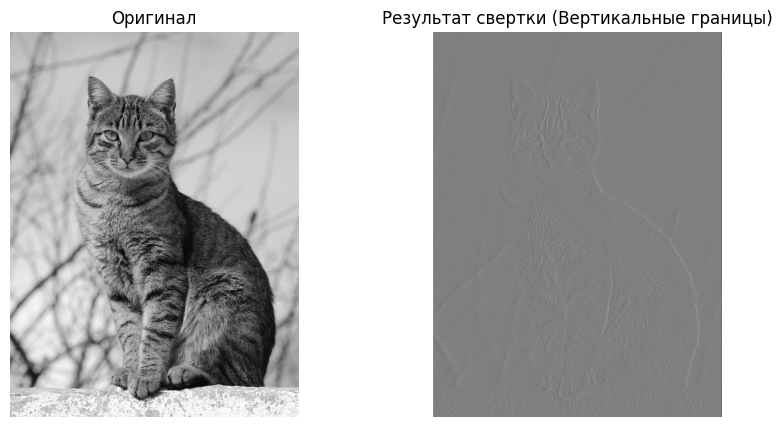

In [3]:
# 2. Определим фильтры (Ядра / Kernels) вручную
# Фильтр выделения вертикальных границ (Sobel)
sobel_kernel = torch.tensor([
    [-1., 0., 1.],
    [-2., 0., 2.],
    [-1., 0., 1.]
]).view(1, 1, 3, 3) # (Out_Channels, In_Channels, H, W)

conv_result = F.conv2d(img_tensor, sobel_kernel, padding=1)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_tensor[0, 0], cmap='gray')
plt.title("Оригинал")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(conv_result[0, 0], cmap='gray')
plt.title("Результат свертки (Вертикальные границы)")
plt.axis('off')

plt.show()


Исходный размер: torch.Size([1, 1, 2397, 1795])
Размер после пулинга: torch.Size([1, 1, 299, 224])


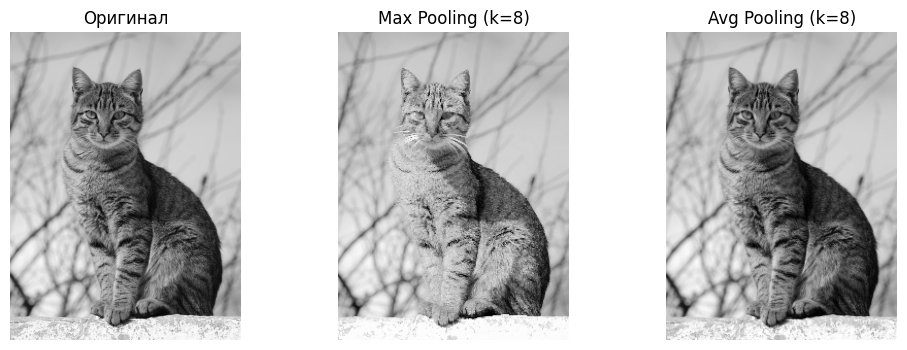

In [4]:
print(f"Исходный размер: {img_tensor.shape}")

kernel_size = 8
stride = 8

max_pool = nn.MaxPool2d(kernel_size=kernel_size, stride=stride)

avg_pool = nn.AvgPool2d(kernel_size=kernel_size, stride=stride)

# Применяем
out_max = max_pool(img_tensor)
out_avg = avg_pool(img_tensor)

print(f"Размер после пулинга: {out_max.shape}")

# Визуализация
plt.figure(figsize=(12, 4))

# 1. Оригинал
plt.subplot(1, 3, 1)
plt.imshow(img_tensor[0, 0], cmap='gray')
plt.title("Оригинал")
plt.axis('off')

# 2. Max Pooling
plt.subplot(1, 3, 2)
plt.imshow(out_max[0, 0], cmap='gray')
plt.title(f"Max Pooling (k={kernel_size})")
plt.axis('off')

# 3. Avg Pooling
plt.subplot(1, 3, 3)
plt.imshow(out_avg[0, 0], cmap='gray')
plt.title(f"Avg Pooling (k={kernel_size})")
plt.axis('off')

plt.show()

## Данные и аугментации

In [6]:
# Трансформации для обучения (Аугментации)
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),      # Случайный поворот лево/право
    transforms.RandomRotation(15),               # Поворот на угол до 15 градусов
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Изменение цвета
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Нормализация [-1, 1]
])

# Трансформации для теста (Только валидация)
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [7]:
# Загрузка датасетов
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                             download=True, transform=train_transforms)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                            download=True, transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170M/170M [05:12<00:00, 545kB/s]  
/home/vladg00dman/Projects/Olympiads/ARSO_AI_practise/.venv/lib/python3.14/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


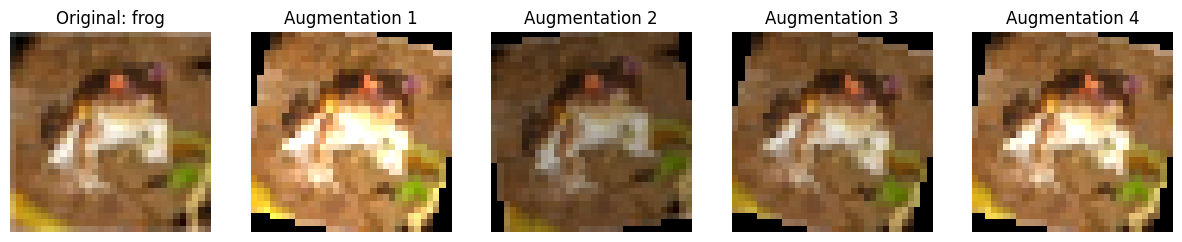

In [10]:
# Берем пример из датасета (отключаем трансформации для чистоты эксперимента)
raw_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=None)
img, label = raw_dataset[0]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
axes[0].imshow(img)
axes[0].set_title(f"Original: {classes[label]}")
axes[0].axis('off')

# Демонстрационный пайплайн аугментаций (без нормализации для корректного цвета)
demo_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.4)
])

for i in range(1, 5):
    aug_img = demo_aug(img)
    axes[i].imshow(aug_img)
    axes[i].set_title(f"Augmentation {i}")
    axes[i].axis('off')

plt.show()


## Модель

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # Блок 1: Свертка -> BN -> ReLU -> Pool
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) # Нормализация каналов
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        
        # Блок 2
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Полносвязная часть
        # 32x32 -> pool -> 16x16 -> pool -> 8x8. Каналов 64.
        self.flatten_dim = 64 * 8 * 8 
        
        self.fc1 = nn.Linear(self.flatten_dim, 512)
        self.dropout = nn.Dropout(0.5) # Выключаем 50% нейронов при обучении
        self.fc2 = nn.Linear(512, 10) # 10 классов

    def forward(self, x):
        # x: (Batch, 3, 32, 32)
        
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        x = x.view(-1, self.flatten_dim) # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Подсчет параметров
print(f"Кол-во параметров: {sum(p.numel() for p in model.parameters())}")


Кол-во параметров: 2122378


## Цикл обучения

In [12]:
def train_model(model, optimizer, criterion, epochs=3):
    train_losses, val_accs = [], []
    
    for epoch in range(epochs):
        model.train() # Переводим в режим обучения (включаем Dropout и BN)
        running_loss = 0.0
        
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()       # Обнуляем градиенты
            outputs = model(inputs)     # Прямой проход
            loss = criterion(outputs, labels) # Ошибка
            loss.backward()             # Обратный проход
            optimizer.step()            # Шаг оптимизатора
            
            running_loss += loss.item()
        
        # Валидация
        model.eval() # Режим оценки (выключаем Dropout)
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        acc = 100 * correct / total
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.3f}, Val Acc: {acc:.2f}%")
        train_losses.append(running_loss/len(train_loader))
        val_accs.append(acc)
    
    return train_losses, val_accs

losses, accs = train_model(model, optimizer, criterion, epochs=10)


Epoch 1, Loss: 1.640, Val Acc: 56.45%
Epoch 2, Loss: 1.360, Val Acc: 59.43%
Epoch 3, Loss: 1.259, Val Acc: 63.40%
Epoch 4, Loss: 1.181, Val Acc: 66.02%
Epoch 5, Loss: 1.141, Val Acc: 68.59%
Epoch 6, Loss: 1.104, Val Acc: 69.85%
Epoch 7, Loss: 1.063, Val Acc: 70.06%
Epoch 8, Loss: 1.037, Val Acc: 72.07%


KeyboardInterrupt: 

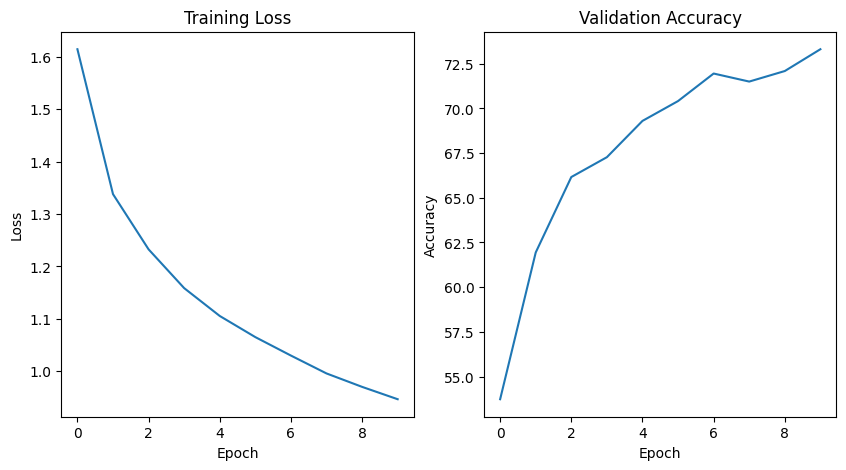

In [ ]:
plt.subplots(1, 2, figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(accs)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## Transfer Learning

In [ ]:
resnet = torchvision.models.resnet18(weights='DEFAULT')

# Заморозка весов (Feature Extractor не учим, он и так умный)
for param in resnet.parameters():
    param.requires_grad = False

In [ ]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10)
resnet = resnet.to(device)

In [ ]:
resnet_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Приходится пересоздать датасеты с новым трансформом
train_dataset_resnet = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                                    download=True, transform=resnet_transforms)
test_dataset_resnet = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                                   download=True, transform=resnet_transforms)

# Batch size поменьше, так как картинки 224x224 едят много памяти
train_loader_resnet = torch.utils.data.DataLoader(train_dataset_resnet, batch_size=32, shuffle=True, num_workers=4)
test_loader_resnet = torch.utils.data.DataLoader(test_dataset_resnet, batch_size=32, shuffle=False, num_workers=4)


In [ ]:
# Оптимизируем веса только у головы
optimizer_resnet = optim.Adam(resnet.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
resnet.train()
for i, (inputs, labels) in enumerate(train_loader_resnet):
    inputs, labels = inputs.to(device), labels.to(device)
    
    optimizer_resnet.zero_grad()
    outputs = resnet(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer_resnet.step()
    
    if i % 100 == 0:
        print(f"Batch {i}, Loss: {loss.item():.3f}")

resnet.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader_resnet:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Val Acc: {100 * correct / total:.2f}%")


Batch 0, Loss: 2.958
Batch 100, Loss: 1.176
Batch 200, Loss: 0.965
Batch 300, Loss: 0.950
Batch 400, Loss: 0.815
Batch 500, Loss: 0.668
Batch 600, Loss: 0.814
Batch 700, Loss: 0.644
Batch 800, Loss: 0.573
Batch 900, Loss: 0.658
Batch 1000, Loss: 0.905
Batch 1100, Loss: 0.578
Batch 1200, Loss: 0.735
Batch 1300, Loss: 0.551
Batch 1400, Loss: 0.950
Batch 1500, Loss: 0.596
Val Acc: 78.23%


## Анализ ошибок

In [ ]:
def show_top_k_errors(model, loader, k=5):
    model.eval()
    errors = [] # (probability, pred_label, true_label, image)
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            # Получаем вероятности через Softmax
            probs = F.softmax(outputs, dim=1)
            max_probs, preds = torch.max(probs, dim=1)
            
            # Маска ошибок
            wrong_mask = (preds != labels)
            
            if wrong_mask.sum() > 0:
                wrong_imgs = inputs[wrong_mask]
                wrong_preds = preds[wrong_mask]
                wrong_probs = max_probs[wrong_mask]
                wrong_labels = labels[wrong_mask]
                
                for i in range(len(wrong_imgs)):
                    errors.append((
                        wrong_probs[i].item(),
                        wrong_preds[i].item(),
                        wrong_labels[i].item(),
                        wrong_imgs[i].cpu()
                    ))

    # Сортируем: сверху самые "уверенные", но неправильные предсказания
    errors.sort(key=lambda x: x[0], reverse=True)
    top_k = errors[:k]
    
    # Визуализация
    plt.figure(figsize=(15, 4))
    for i, (prob, pred, true, img) in enumerate(top_k):
        img = img / 2 + 0.5 # Denormalize
        npimg = img.numpy()
        
        plt.subplot(1, k, i+1)
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.title(f"True: {classes[true]}\nPred: {classes[pred]}\nConf: {prob:.2f}", color='red')
        plt.axis('off')
    plt.show()

Топ самых уверенных ошибок модели:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


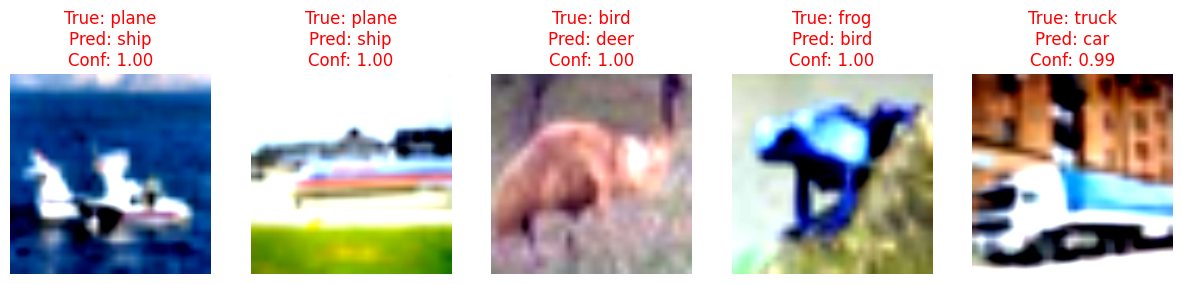

In [ ]:
print("Топ самых уверенных ошибок модели:")
show_top_k_errors(resnet, test_loader_resnet, k=5)


Топ самых уверенных ошибок модели:


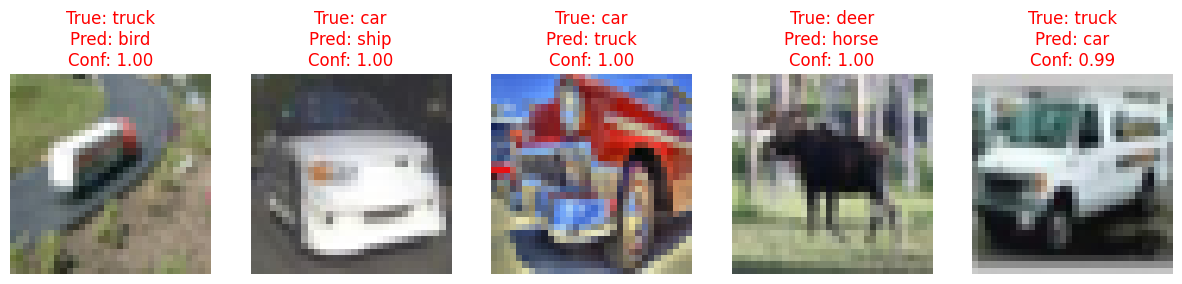

In [ ]:
print("Топ самых уверенных ошибок модели:")
show_top_k_errors(model, test_loader, k=5)

Размер карт признаков: torch.Size([1, 64, 16, 16])


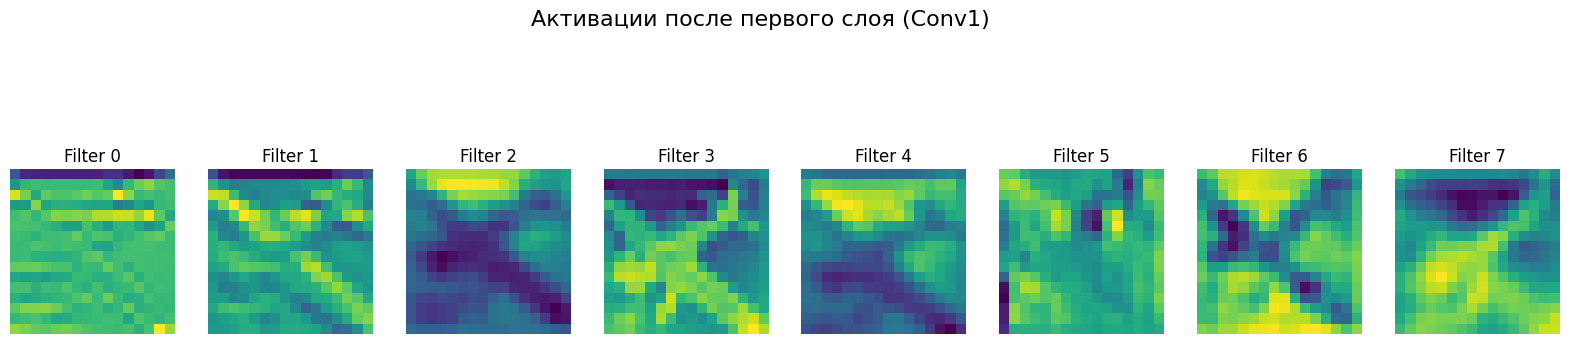

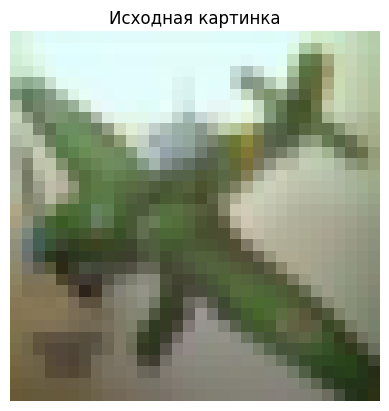

In [ ]:
first_layer = resnet.conv1

# Берем картинку из теста
img, _ = test_dataset[27] # Какая-то картинка
img_tensor = img.unsqueeze(0).to(device) # Добавляем батч

# Прогоняем через первый слой
with torch.no_grad():
    feature_maps = first_layer(img_tensor) # Результат (1, 64, H/2, W/2)

print(f"Размер карт признаков: {feature_maps.shape}")

# Рисуем первые 8 фильтров
fig, axes = plt.subplots(1, 8, figsize=(20, 5))
for i in range(8):
    fmap = feature_maps[0, i].cpu()
    axes[i].imshow(fmap, cmap='viridis') # viridis для контраста
    axes[i].axis('off')
    axes[i].set_title(f"Filter {i}")

fig.suptitle('Активации после первого слоя (Conv1)', fontsize=16)
plt.show()

# Покажем саму картинку для сравнения
plt.imshow(img.permute(1, 2, 0) / 2 + 0.5)
plt.title("Исходная картинка")
plt.axis('off')
plt.show()